## Import required packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Create Dataframes for each dataset

In [ ]:
ta_df = pd.read_csv('../../data/bitcoin-all-technical-indicators.csv') 
ta_df['timestamp'] = pd.to_datetime(ta_df['timestamp'])
oc_df = pd.read_csv('../../data/bitcoin-all-on-chain.csv')
oc_df['timestamp'] = pd.to_datetime(oc_df['timestamp'])
oc_ta_df = pd.read_csv('../../data/bitcoin-all-on-chain-and-technical-indicators.csv')
oc_ta_df['timestamp'] = pd.to_datetime(oc_ta_df['timestamp'])


## Visualisation function

In [ ]:
def plot_values(timestamp, *args):
    import matplotlib

    if len(args) % 2 != 0:
        raise ValueError("Every feature should have a corresponding name")

    # Use a predefined style
    plt.style.use('ggplot')

    # Set figure size
    fig, ax = plt.subplots(figsize=(12,6))

    # Create a colormap that will generate colors
    colormap = matplotlib.colormaps['tab10']

    # Plot data with customized line for each feature
    for i in range(0, len(args), 2):
        feature_name = args[i]
        feature_values = args[i+1]
        color = colormap(i // 2 / (len(args)//2))
        ax.plot(timestamp, feature_values, label=feature_name, color=color, linewidth=1)

    # Set labels with improved readability
    ax.set_xlabel('Date')
    ax.yaxis.set_label_position("right") # This line moves y label to the right
    ax.set_ylabel('Feature Values')
    ax.yaxis.tick_right() # This line moves y axis to the right
    ax.set_title('Features over Time')

    # Format the timestamps and set locator
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format as year-month-day
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # display a label at the start of every 3rd month

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add a grid
    ax.grid(True)

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

#Usage:    
#plot_values(ta_df['timestamp'], 'price', ta_df['price'], 'price+500', ta_df['price']+500)

## Data Preperation Function for predicting price

In [ ]:
def data_preperation(df, lookback, future, scale, test_size=0.1):
    # Convert 'Date' column to datetime
    date_train = pd.to_datetime(df['timestamp'])
    df = df.drop(columns=['timestamp'])

    # Ensure all data is float type
    df = df.astype(float)

    # Split data into training and testing before scaling
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

    # Scale data
    df_train_scaled = scale.fit_transform(df_train)
    df_test_scaled = scale.transform(df_test)  # use the scaler fitted on the training data

    # Create the feature and target arrays
    X_train, y_train = [], []
    for i in range(lookback, len(df_train_scaled)-future+1):
        X_train.append(df_train_scaled[i-lookback:i, :])
        y_train.append(df_train_scaled[i+future-1:i+future, 0])

    X_test, y_test = [], []
    for i in range(lookback, len(df_test_scaled)-future+1):
        X_test.append(df_test_scaled[i-lookback:i, :])
        y_test.append(df_test_scaled[i+future-1:i+future, 0])

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test, date_train

#Usage: 
#scale = MinMaxScaler(feature_range=(0,1))
#X_train, X_test, y_train, y_test, date_train = data_preperation(ta_df, 30, 1, scale)


In [ ]:
## Data Preperation Function for predicting returns

In [39]:
def data_preparation_returns(df, lookback, future, scale_full, scale_returns, test_size=0.1):
    # Convert 'Date' column to datetime
    date_train = pd.to_datetime(df['timestamp'])
    df = df.drop(columns=['timestamp'])

    # Ensure all data is float type
    df = df.astype(float)

    # Calculate return from price 
    df['return'] = df['price'].diff()
    df = df.dropna()  # remove the first row which is NaN

    # Now drop the 'price' column as we won't use it anymore
    df = df.drop(columns=['price'])

    # Split data into training and testing before scaling
    df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

    # Scale full data
    df_train_scaled = pd.DataFrame(scale_full.fit_transform(df_train), columns=df_train.columns)
    df_test_scaled = pd.DataFrame(scale_full.transform(df_test), columns=df_test.columns)

    # Scale 'return' column alone
    df_train_scaled['return'] = scale_returns.fit_transform(df_train[['return']])
    df_test_scaled['return'] = scale_returns.transform(df_test[['return']])

    # Create the feature and target arrays
    X_train, y_train = [], []
    for i in range(lookback, len(df_train_scaled)-future+1):
        X_train.append(df_train_scaled.iloc[i-lookback:i, :].values)
        y_train.append(df_train_scaled.iloc[i+future-1:i+future][['return']].values)

    X_test, y_test = [], []
    for i in range(lookback, len(df_test_scaled)-future+1):
        X_test.append(df_test_scaled.iloc[i-lookback:i, :].values)
        y_test.append(df_test_scaled.iloc[i+future-1:i+future][['return']].values)

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test, date_train


In [6]:
def model_checkpoint(model_name, save_path="model_checkpoints"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor="val_loss",
                                              verbose=0, 
                                              save_best_only=True)

In [53]:
## Model 1. Lstm

In [7]:
def lstm_1(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)

    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dense(25))
    model.add(Dense(1))
    
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y, validation_split=0.2, epochs=10, batch_size=32, callbacks=[model_checkpoint(model_name=model.name)])
    return model

In [8]:
def lstm_2(X, y):
    model_name="lstm_1_"+str(int(time.time()))
    model=Sequential(name=model_name)
    
    
    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(15,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)

    model.fit(X, y,validation_split=0.2,epochs=100,batch_size=32,verbose=1, callbacks=[model_checkpoint(model_name=model.name)])
    return model

In [43]:
scale = MinMaxScaler(feature_range=(0,1))
X_train, X_test, y_train, y_test, date_train = data_preperation(ta_df, 60, 1, scale)
model=lstm_1(X_train, y_train)
predictions = model.predict(X_test)
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scale.min_[0], scale.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)
y_test = y_test.reshape(-1, 1)  # reshaping
y_test = price_scaler.inverse_transform(y_test)


# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# R-squared (R2)
r2 = r2_score(y_test, predictions)
print("R-squared (R2):", r2)

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.0665

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 95s 1s/step - loss: 0.0665 - val_loss: 0.0729
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 6.7080e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 83s 1s/step - loss: 6.7080e-04 - val_loss: 0.0528
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 4.5799e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 93s 1s/step - loss: 4.5799e-04 - val_loss: 0.0467
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 3.8654e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 88s 1s/step - loss: 3.8654e-04 - val_loss: 0.0439
Epoch 5/10
65/65 [==============================] - ETA: 0s - loss: 3.1876e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 87s 1s/step - loss: 3.1876e-04 - val_loss: 0.0419
Epoch 6/10
65/65 [==============================] - 73s 1s/step - loss: 2.8033e-04 - val_loss: 0.0434
Epoch 7/10
65/65 [==============================] - ETA: 0s - loss: 2.6530e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 92s 1s/step - loss: 2.6530e-04 - val_loss: 0.0384
Epoch 8/10
65/65 [==============================] - ETA: 0s - loss: 2.1580e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


65/65 [==============================] - 99s 2s/step - loss: 2.1580e-04 - val_loss: 0.0361
Epoch 9/10
65/65 [==============================] - 74s 1s/step - loss: 2.1062e-04 - val_loss: 0.0386
Epoch 10/10
65/65 [==============================] - ETA: 0s - loss: 1.8923e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688221121\assets


8/8 [==============================] - 3s 225ms/step
Mean Absolute Error (MAE): 1258.2667874380388
Mean Squared Error (MSE): 3129112.480994201
Root Mean Squared Error (RMSE): 1768.92975581118
Mean Absolute Percentage Error (MAPE): 5.524314582415666
R-squared (R2): 0.8050153836904287


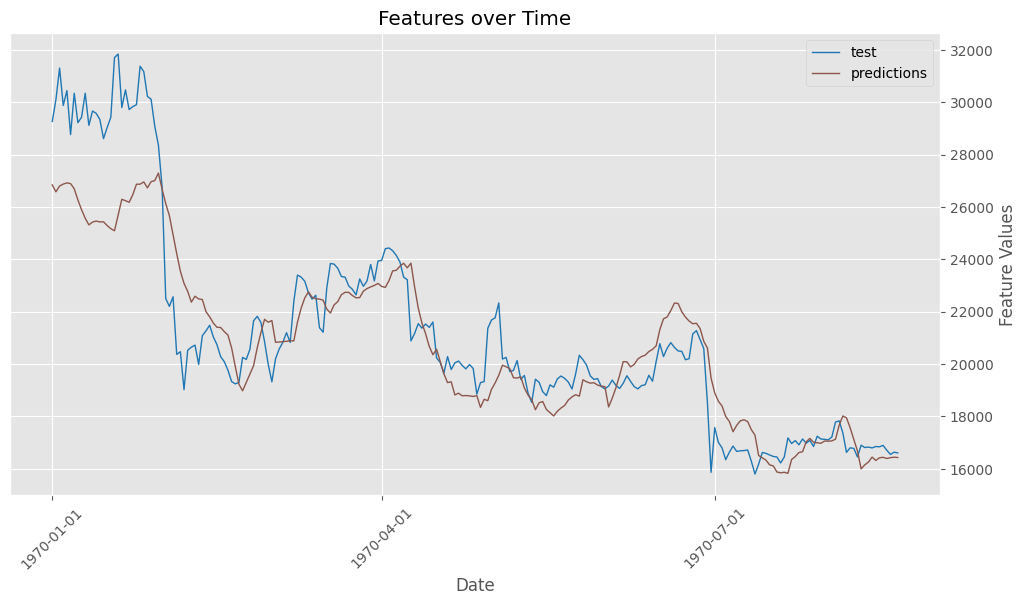

In [44]:
plot_values(range(232), 'test', y_test, 'predictions', predictions)

In [40]:
# Create separate scalers for the full data and the 'returns' column
scale_full = MinMaxScaler(feature_range=(0,1))
scale_returns = MinMaxScaler(feature_range=(0,1))

X_train, X_test, y_train, y_test, date_train = data_preparation_returns(ta_df, 60, 1, scale_full, scale_returns)
model = lstm_1(X_train, y_train)
predictions = model.predict(X_test)

# Inverse transform the predictions and y_test 
predictions = scale_returns.inverse_transform(predictions)
y_test = y_test.reshape(-1, 1)  # reshaping
y_test = scale_returns.inverse_transform(y_test)

# Convert returns back to price for plotting and error metrics.
df_train, df_test = train_test_split(ta_df, test_size=0.1, shuffle=False)

# For the actual values
price_test = df_test['price'][60:].values  # adjust the index according to your lookback period
price_test = np.concatenate(([df_train['price'].iloc[-1]], price_test))
y_test_price = np.cumsum(y_test) + price_test[:-1]

# For the predictions
predictions_price = np.cumsum(predictions) + price_test[:-1]

# Now you can calculate the error metrics on the price data
mae = mean_absolute_error(y_test_price, predictions_price)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test_price, predictions_price)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mean_squared_error(y_test_price, predictions_price))
print("Root Mean Squared Error (RMSE):", rmse)

mape = np.mean(np.abs((y_test_price - predictions_price) / y_test_price)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

r2 = r2_score(y_test_price, predictions_price)
print("R-squared (R2):", r2)


Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.0498

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


65/65 [==============================] - 87s 1s/step - loss: 0.0498 - val_loss: 0.0155
Epoch 2/10
65/65 [==============================] - 66s 1s/step - loss: 9.1221e-04 - val_loss: 0.0155
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 8.4770e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


65/65 [==============================] - 83s 1s/step - loss: 8.4770e-04 - val_loss: 0.0155
Epoch 4/10
65/65 [==============================] - 64s 978ms/step - loss: 7.5107e-04 - val_loss: 0.0160
Epoch 5/10
65/65 [==============================] - 63s 976ms/step - loss: 7.3752e-04 - val_loss: 0.0157
Epoch 6/10
65/65 [==============================] - 64s 979ms/step - loss: 6.5868e-04 - val_loss: 0.0157
Epoch 7/10
65/65 [==============================] - 64s 979ms/step - loss: 6.7510e-04 - val_loss: 0.0160
Epoch 8/10
65/65 [==============================] - 63s 977ms/step - loss: 7.0599e-04 - val_loss: 0.0160
Epoch 9/10
65/65 [==============================] - ETA: 0s - loss: 6.1232e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


65/65 [==============================] - 82s 1s/step - loss: 6.1232e-04 - val_loss: 0.0154
Epoch 10/10
65/65 [==============================] - ETA: 0s - loss: 6.2134e-04

INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


INFO:tensorflow:Assets written to: model_checkpoints\lstm_1_1688220177\assets


8/8 [==============================] - 3s 241ms/step
Mean Absolute Error (MAE): 6575.007554453949
Mean Squared Error (MSE): 76204635.8329027
Root Mean Squared Error (RMSE): 8729.52666717404
Mean Absolute Percentage Error (MAPE): 106.75710371210434
R-squared (R2): -0.1623268641017066


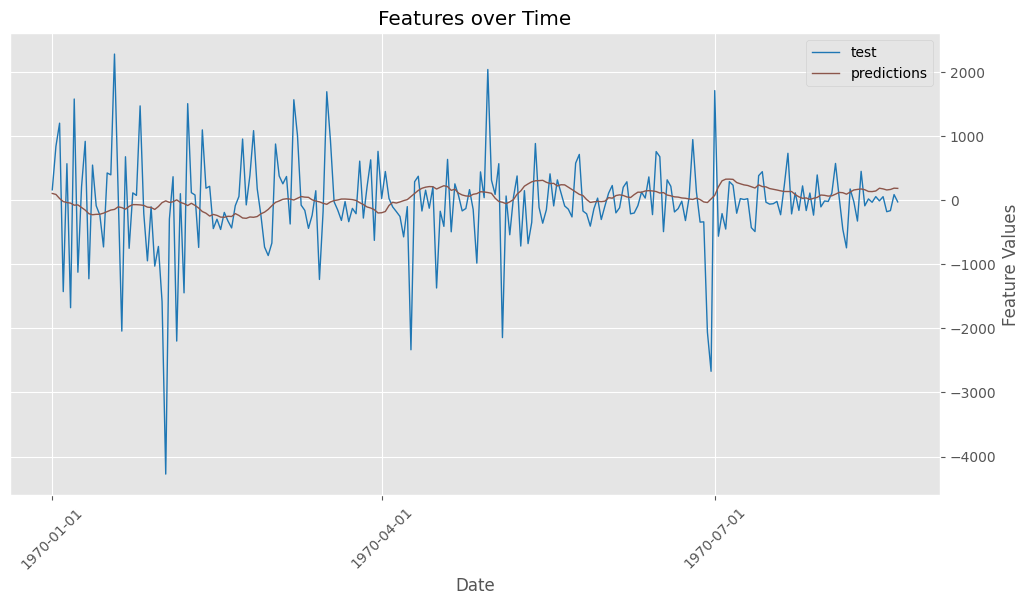

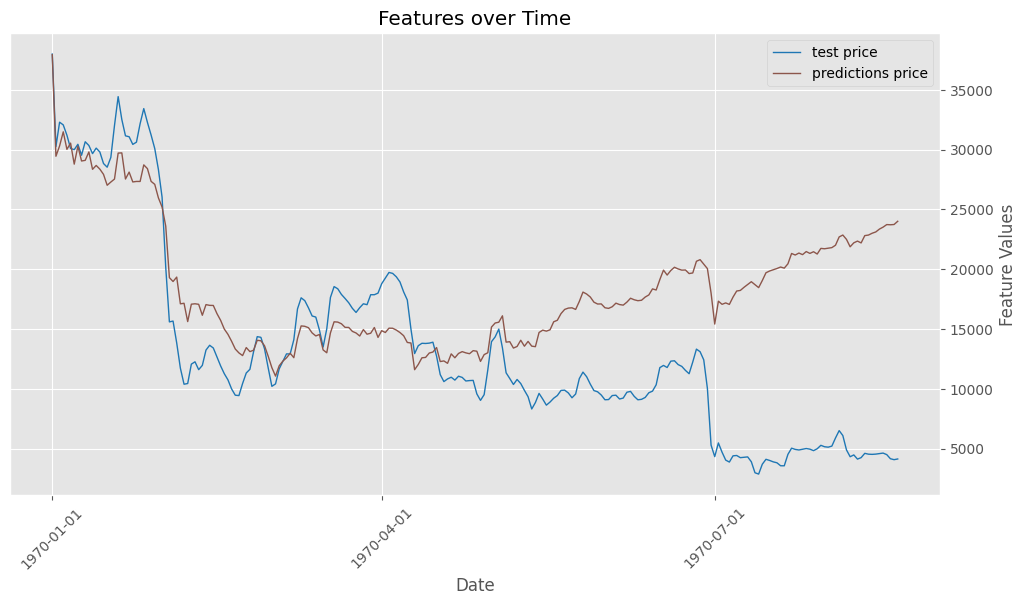

In [41]:
plot_values(range(232), 'test', y_test, 'predictions', predictions)
plot_values(range(232), 'test price', y_test_price, 'predictions price', predictions_price)

In [42]:
# Now you can calculate the error metrics on the return data
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

r2 = r2_score(y_test, predictions)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 491.90457195760285
Mean Squared Error (MSE): 557736.123575443
Root Mean Squared Error (RMSE): 746.8173294557666
Mean Absolute Percentage Error (MAPE): 168.4540210422314
R-squared (R2): -0.043861614510464664
